0To train the model, the project utilizes a UTKFace dataset containing labeled facial images. The labels of each face image is embedded in the file name,
formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age

[gender] is either 0 (male) or 1 (female)

[race] is an integer from 0 to 4, denoting White=0, Black=1, Asian=2, Indian=3, and Others=4 (like Hispanic, Latino, Middle Eastern).

[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [1]:
import os
import re
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import tensorflow.keras.applications
from PIL import Image
import cv2
import pickle
import tensorflow as tf
from keras.losses import huber_loss
from pydeck.bindings import layer
from scipy.special.cython_special import eval_sh_legendre
from tensorflow.compiler.tf2xla.python.xla import while_loop
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.python.keras.callbacks import ModelCheckpoint

2025-07-14 22:39:39.847304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Handle File names to extact age gender race

In [2]:
# add file folder path dir and using regular expression to
# parse the filenames

dataset_path = '../data/utkface_dataset'
pattern = r"(\d+)_(\d)_(\d)_(\d+).jpg"

image_size = (300, 300)
batch_size = 32

def parse_label(filename):
    match = re.match(pattern, filename)
    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        race = int(match.group(3))
        return age, gender, race
    else:
        raise IOError(f'{filename} Invalid filename')


Raw dataset preparation

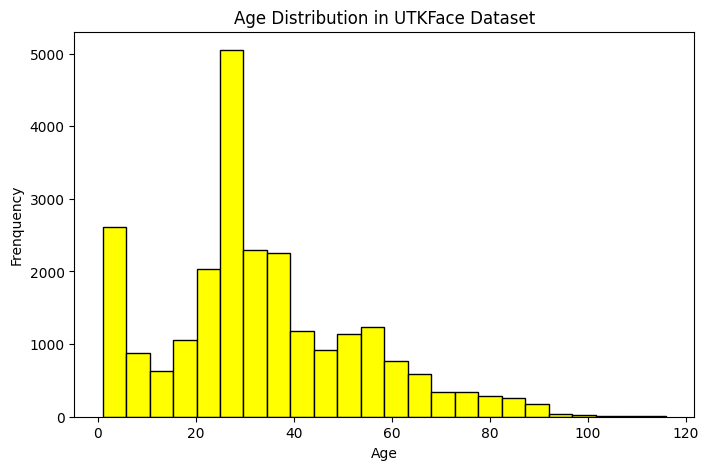

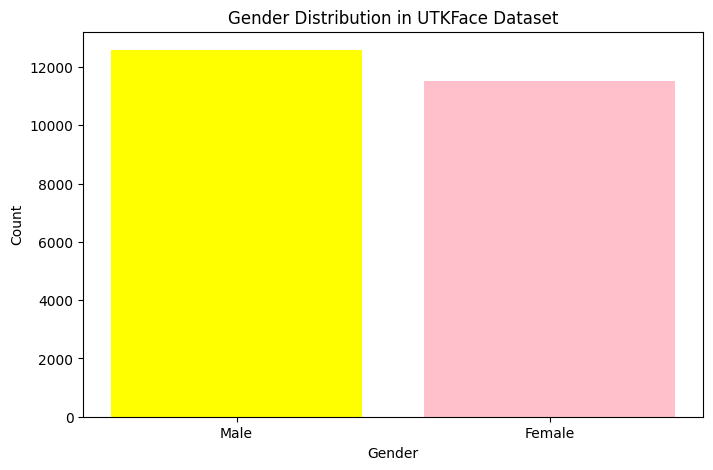

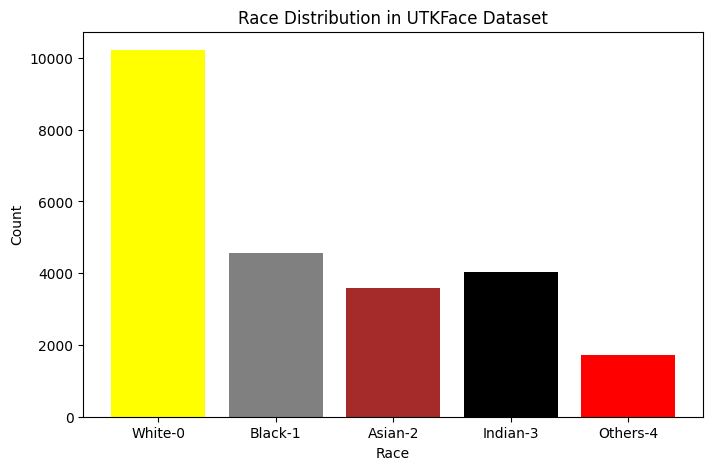

In [3]:
def plot_distribution(files):
    ages = [parse_label(os.path.basename(f))[0] for f in files]
    genders = [parse_label(os.path.basename(f))[1] for f in files]
    races = [parse_label(os.path.basename(f))[2] for f in files]

    plt.figure(figsize=(8, 5))
    plt.hist(ages, bins=24, color='yellow', edgecolor='black')
    plt.title('Age Distribution in UTKFace Dataset')
    plt.xlabel('Age')
    plt.ylabel('Frenquency')
    plt.show()

    plt.figure(figsize=(8, 5))
    gender_count = Counter(genders)
    plt.bar(gender_count.keys(), gender_count.values(), color=['yellow', 'pink'])
    plt.xticks([0,1], ['Male', 'Female'])
    plt.title('Gender Distribution in UTKFace Dataset')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

    plt.figure(figsize=(8, 5))
    race_counts = Counter(races)
    # White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
    plt.bar(race_counts.keys(), race_counts.values(), color=['gray','black', 'yellow', 'brown', 'red'])
    plt.xticks([0,1,2,3,4],['White-0', 'Black-1', 'Asian-2', 'Indian-3', 'Others-4'])
    plt.title('Race Distribution in UTKFace Dataset')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.show()

all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpg')]

plot_distribution(all_files)




the value of target_per_bin  1000
the length of the downsampled_files  12865


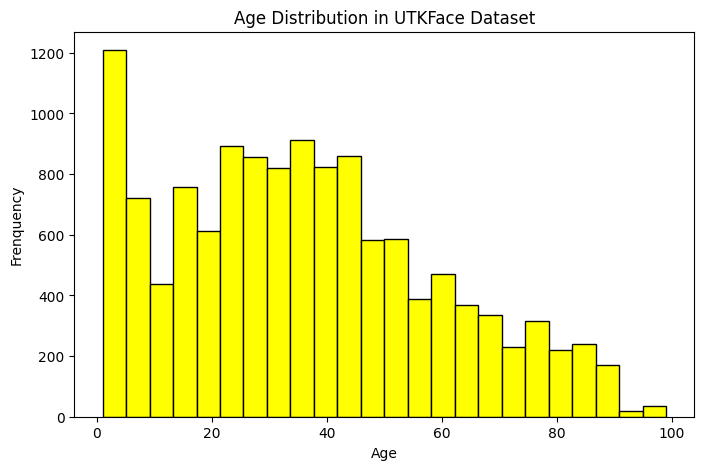

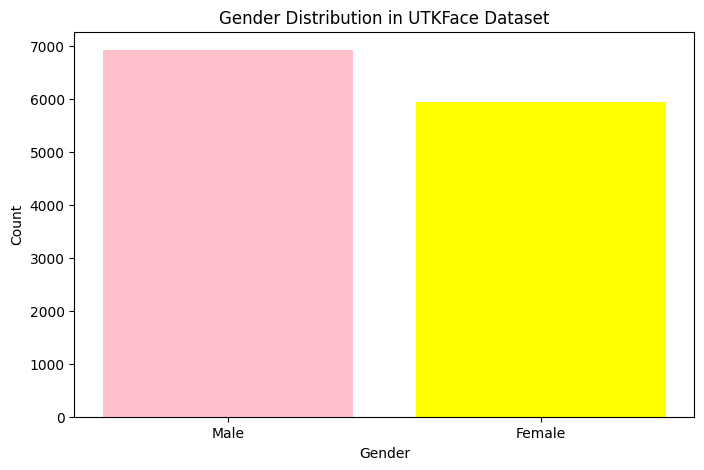

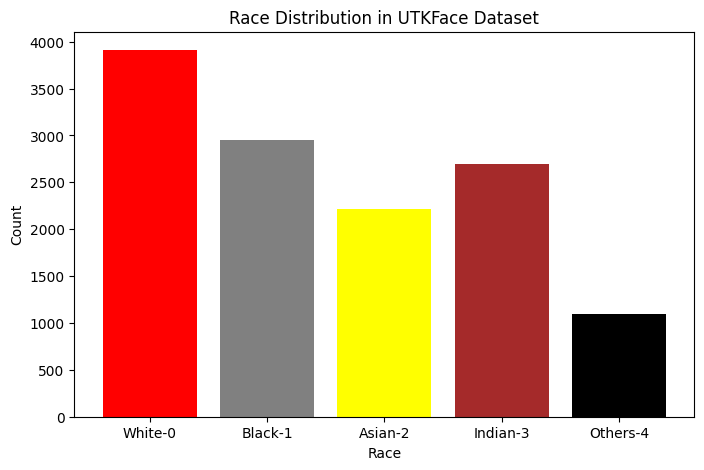

In [4]:
def stratified_downsampling(files, age_bins, target_per_bin=1000):
    # in this function
    # files : images file list
    # age_bins: each age segment
    # target_per_bin: the number of images left in each age bins.
    random.seed(42)
    print("the value of target_per_bin ", target_per_bin)

    race_white = 0
    age_to_files = {i: [] for i in range(len(age_bins) - 1)}

    for f in files:
        age, _, race = parse_label(os.path.basename(f))
        for i in range(len(age_bins)-1):
            if age_bins[i] <= age < age_bins[i+1]:
                age_to_files[i].append((f, race))
                break

    selected_files = []
    for age_bin_idx, age_bin_files in age_to_files.items():
        if len(age_bin_files) > target_per_bin:
            white_files = [f for f, race in age_bin_files if race==race_white]

            non_white_files = [f for f, race in age_bin_files if race != race_white]

            if len(non_white_files)> target_per_bin:
                 selected_files.extend(random.sample(non_white_files, target_per_bin))
            else:
                selected_files.extend(non_white_files)
                remaining_needed = target_per_bin - len(non_white_files)
                selected_files.extend(random.sample(white_files, remaining_needed))
        else:
            selected_files.extend([f for f, _ in age_bin_files])
    return selected_files

age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

downsampled_files = stratified_downsampling(all_files, age_bins, target_per_bin=1000)

print("the length of the downsampled_files ", len(downsampled_files))

plot_distribution(downsampled_files)

image file names:  ../data/utkface_dataset/86_1_0_20170110180113129.jpg
image file names:  ../data/utkface_dataset/45_0_0_20170117183147982.jpg
image file names:  ../data/utkface_dataset/71_0_1_20170113175251268.jpg
image file names:  ../data/utkface_dataset/20_0_2_20170117135024223.jpg
image file names:  ../data/utkface_dataset/32_1_1_20170116164948959.jpg


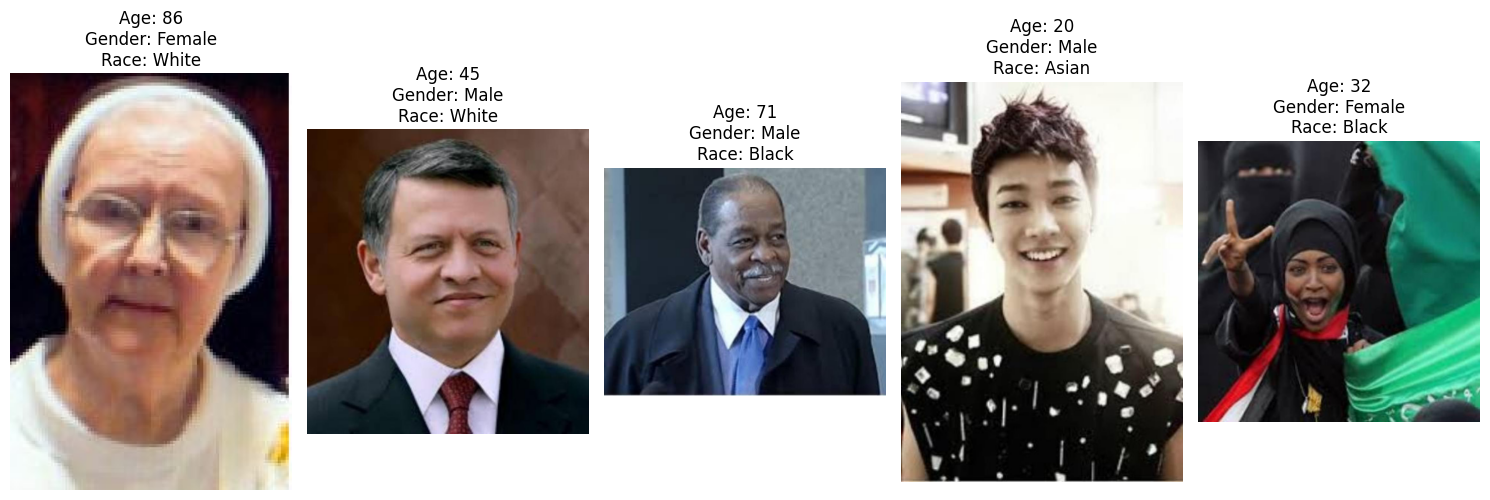

In [5]:
# Convert gender and race to string labels
def convert_labels(age, gender, race):
    gender_label = "Male" if gender == 0 else "Female"
    race_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}
    race_label = race_dict.get(race, "Unknown")
    return age, gender_label, race_label

random_files = random.sample(downsampled_files, 5)

plt.figure(figsize=(15, 10))


for i, file_name in enumerate(random_files):


    img_path = file_name
    # img = Image.open(img_path).convert('RGB')
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {file_name}: {e}")
        continue

    base_name = os.path.basename(file_name)
    age, gender, race = parse_label(base_name)
    age, gender_label, race_label = convert_labels(age, gender, race)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Age: {age}\nGender: {gender_label}\nRace: {race_label}")
    print("image file names: ", file_name)

plt.tight_layout()
plt.show()

In [6]:
def load_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = preprocess_input(image)

    age, gender, race = label
    return image, (age, gender, race)


def create_dataset(image_files):
    labels = [parse_label(os.path.basename(file)) for file in image_files]
    ages = tf.constant([label[0] for label in labels], dtype=tf.int32)
    genders = tf.constant([label[1] for label in labels], dtype=tf.int32)
    races = tf.constant([label[2] for label in labels], dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((image_files, (ages, genders, races)))
    dataset = dataset.map(lambda x, y: (load_image(x, y)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [7]:
# Get all image files
total_files = len(downsampled_files)

# Shuffle files with a consistent seed
seed = 42
random.seed(seed)
random.shuffle(downsampled_files)

# Split the data into train, validation, and test
train_split = 0.5
val_split = 0.25
test_split = 0.25

train_count = int(total_files * train_split)
val_count = int(total_files * val_split)

train_files = downsampled_files[:train_count]
val_files = downsampled_files[train_count:train_count + val_count]
test_files = downsampled_files[train_count + val_count:]

# Create dataset for each subset
train_ds = create_dataset(train_files)
val_ds = create_dataset(val_files)
test_ds = create_dataset(test_files)

2025-07-14 22:39:48.430800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Corrupt JPEG data: premature end of data segment


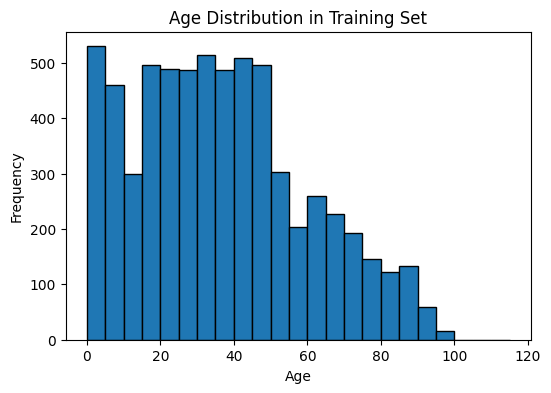

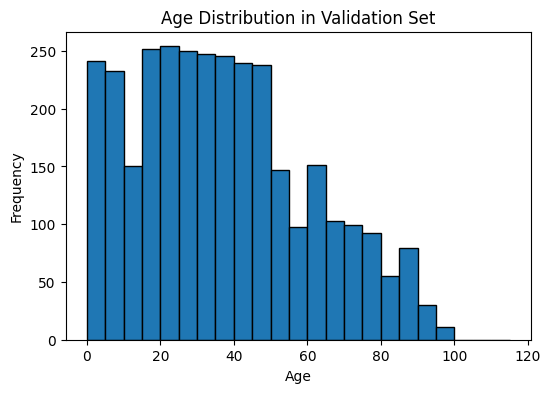

Corrupt JPEG data: premature end of data segment
2025-07-14 22:40:41.310623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


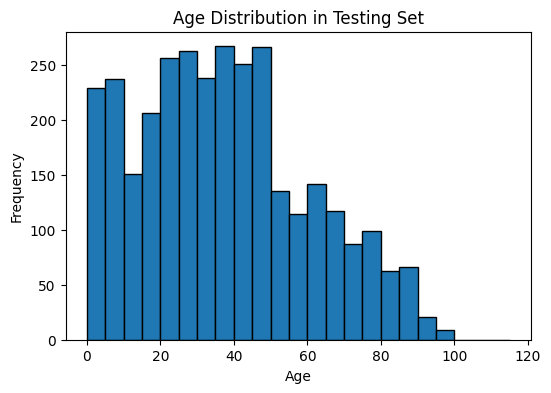

In [8]:
def plot_age_distribution(dataset, subset_name):
    ages = []
    for _, (age_labels, _, _) in dataset:
        ages.extend(age_labels.numpy())

    plt.figure(figsize=(6, 4))
    plt.hist(ages, bins=range(0, 120, 5), edgecolor='black')
    plt.title(f"Age Distribution in {subset_name} Set")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()

# Plot age distributions for training, validation, and test sets
plot_age_distribution(train_ds, "Training")
plot_age_distribution(val_ds, "Validation")
plot_age_distribution(test_ds, "Testing")

Corrupt JPEG data: premature end of data segment


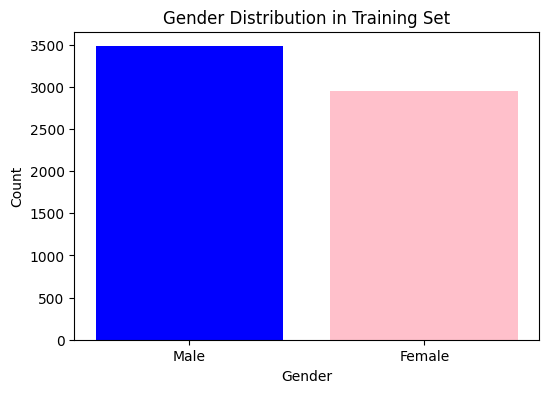

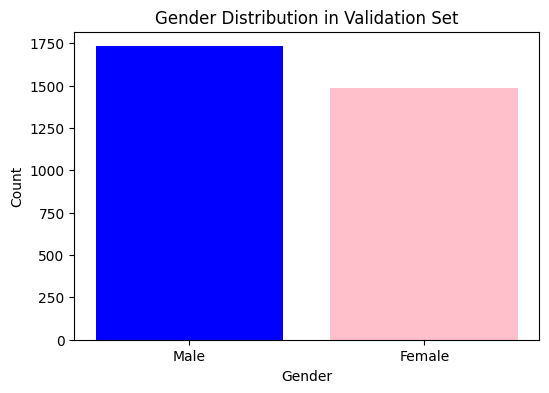

Corrupt JPEG data: premature end of data segment
2025-07-14 22:41:22.064628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


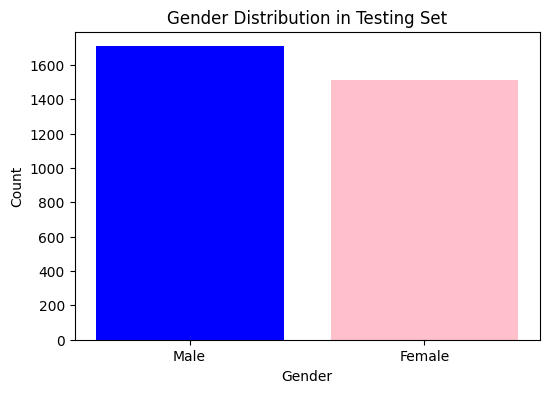

In [9]:
def plot_gender_distribution(dataset, subset_name):
    gender_count = {0: 0, 1: 0}
    for _, (_, gender_labels, _) in dataset:
        unique, counts = np.unique(gender_labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            gender_count[u] += c

    plt.figure(figsize=(6, 4))
    plt.bar(['Male', 'Female'], [gender_count[0], gender_count[1]], color=['blue', 'pink'])
    plt.title(f"Gender Distribution in {subset_name} Set")
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.show()

# Plot gender distributions for training, validation, and test sets
plot_gender_distribution(train_ds, "Training")
plot_gender_distribution(val_ds, "Validation")
plot_gender_distribution(test_ds, "Testing")

Corrupt JPEG data: premature end of data segment


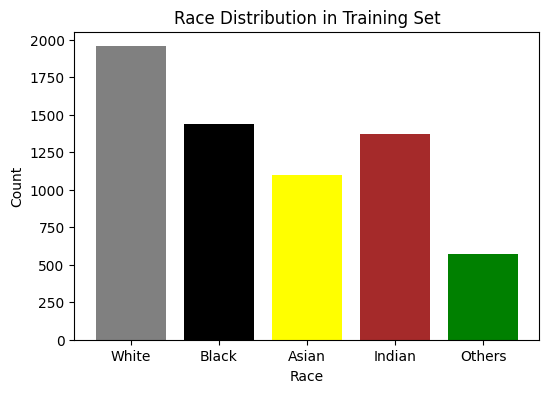

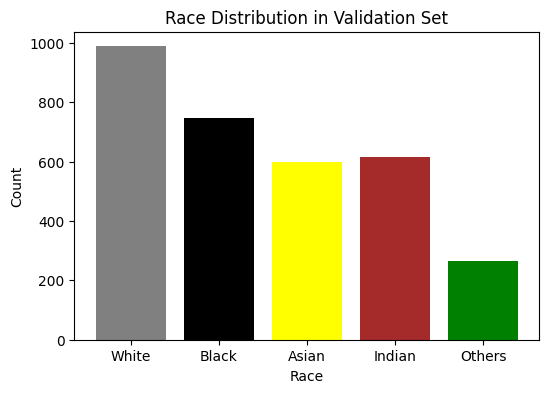

Corrupt JPEG data: premature end of data segment
2025-07-14 22:42:19.859206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


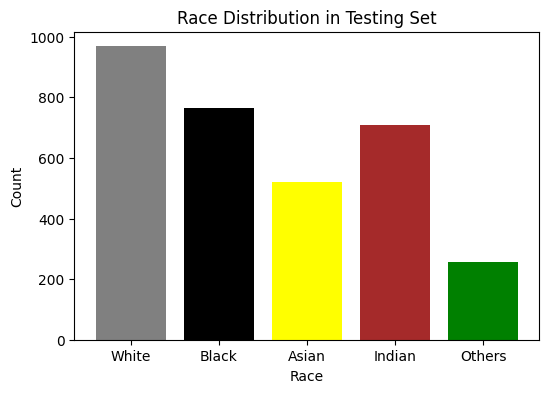

In [10]:
def plot_race_distribution(dataset, subset_name):
    race_count = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    for _, (_, _, race_labels) in dataset:
        unique, counts = np.unique(race_labels.numpy(), return_counts=True)
        for u, c in zip(unique, counts):
            race_count[u] += c

    plt.figure(figsize=(6, 4))
    plt.bar(['White', 'Black', 'Asian', 'Indian', 'Others'],
            [race_count[i] for i in range(5)], color=['gray', 'black', 'yellow', 'brown', 'green'])
    plt.title(f"Race Distribution in {subset_name} Set")
    plt.xlabel("Race")
    plt.ylabel("Count")
    plt.show()

# Plot race distributions for training, validation, and test sets
plot_race_distribution(train_ds, "Training")
plot_race_distribution(val_ds, "Validation")
plot_race_distribution(test_ds, "Testing")

In [11]:
input_shape = (300,300,3)
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights=None,
    input_shape=input_shape
)

weights_path = os.path.join('../weights', 'efficientnetv2-s_notop.h5')

base_model.load_weights(weights_path)

base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 150, 150, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [12]:
# input_shape = (224, 224, 3)
#
# # Load the pretrained EfficientNetB0 model with imagenet weights and exclude the top layers
# base_model1 = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
# base_model1.summary()

In [13]:
# freeze all the layer in efficientnetv2s, except for the 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [14]:
#freeze all layers and adding age, gender, race output
inputs = tf.keras.layers.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)

dense_age = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
bn_age = layers.BatchNormalization()(dense_age)
dropout_age = layers.Dropout(0.5)(bn_age)
age_output = layers.Dense(1, activation='relu', name='age')(dropout_age)

dense_gender = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
bn_gender = layers.BatchNormalization()(dense_gender)
dropout_gender = layers.Dropout(0.5)(bn_gender)
gender_output = layers.Dense(1, activation='sigmoid', name='gender')(dropout_gender)

dense_race = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
bn_race = layers.BatchNormalization()(dense_race)
dropout_race = layers.Dropout(0.5)(bn_race)
race_output = layers.Dense(5, activation='softmax', name='race')(dropout_race)

model = Model(inputs=inputs, outputs=[age_output, gender_output, race_output])

In [15]:
huber_loss = Huber()
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        'age': huber_loss,
        'gender': 'binary_crossentropy',
        'race': 'sparse_categorical_crossentropy',
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy',
        'race': 'accuracy',
    }
)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetv2-s (Functional)  (None, 10, 10, 1280  20331360    ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetv2-s[0][0]']       
 alAveragePooling2D)                                                                          

In [17]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_efficientnetv2s.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [18]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/50
 58/201 [=======>......................] - ETA: 13:03 - loss: 38.4370 - age_loss: 30.1943 - gender_loss: 0.3993 - race_loss: 1.6573 - age_mae: 30.6928 - gender_accuracy: 0.8346 - race_accuracy: 0.4709

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 29.3968 - age_loss: 23.2493 - gender_loss: 0.3504 - race_loss: 1.3312 - age_mae: 23.7467 - gender_accuracy: 0.8567 - race_accuracy: 0.5389
Epoch 00001: val_loss improved from inf to 20.38533, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1763s 9s/step - loss: 29.3968 - age_loss: 23.2493 - gender_loss: 0.3504 - race_loss: 1.3312 - age_mae: 23.7467 - gender_accuracy: 0.8567 - race_accuracy: 0.5389 - val_loss: 20.3853 - val_age_loss: 16.4203 - val_gender_loss: 0.2854 - val_race_loss: 1.0587 - val_age_mae: 16.9181 - val_gender_accuracy: 0.8837 - val_race_accuracy: 0.6281 - lr: 0.0010
Epoch 2/50
 58/201 [=======>......................] - ETA: 13:17 - loss: 19.0402 - age_loss: 15.3956 - gender_loss: 0.2819 - race_loss: 1.0286 - age_mae: 15.8904 - gender_accuracy: 0.8847 - race_accuracy: 0.6261

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 16.5093 - age_loss: 13.3935 - gender_loss: 0.2813 - race_loss: 0.9768 - age_mae: 13.8878 - gender_accuracy: 0.8870 - race_accuracy: 0.6424
Epoch 00002: val_loss improved from 20.38533 to 14.16546, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1587s 8s/step - loss: 16.5093 - age_loss: 13.3935 - gender_loss: 0.2813 - race_loss: 0.9768 - age_mae: 13.8878 - gender_accuracy: 0.8870 - race_accuracy: 0.6424 - val_loss: 14.1655 - val_age_loss: 11.4707 - val_gender_loss: 0.3285 - val_race_loss: 1.0494 - val_age_mae: 11.9659 - val_gender_accuracy: 0.8616 - val_race_accuracy: 0.6415 - lr: 0.0010
Epoch 3/50
 58/201 [=======>......................] - ETA: 12:14 - loss: 13.3107 - age_loss: 10.9085 - gender_loss: 0.2556 - race_loss: 0.9215 - age_mae: 11.4016 - gender_accuracy: 0.9025 - race_accuracy: 0.6616

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 12.7899 - age_loss: 10.5720 - gender_loss: 0.2671 - race_loss: 0.8763 - age_mae: 11.0639 - gender_accuracy: 0.8979 - race_accuracy: 0.6831
Epoch 00003: val_loss improved from 14.16546 to 13.25016, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1503s 7s/step - loss: 12.7899 - age_loss: 10.5720 - gender_loss: 0.2671 - race_loss: 0.8763 - age_mae: 11.0639 - gender_accuracy: 0.8979 - race_accuracy: 0.6831 - val_loss: 13.2502 - val_age_loss: 11.1133 - val_gender_loss: 0.2666 - val_race_loss: 0.9620 - val_age_mae: 11.6047 - val_gender_accuracy: 0.8955 - val_race_accuracy: 0.6701 - lr: 0.0010
Epoch 4/50
 58/201 [=======>......................] - ETA: 12:03 - loss: 11.8284 - age_loss: 9.8783 - gender_loss: 0.2500 - race_loss: 0.8264 - age_mae: 10.3713 - gender_accuracy: 0.9133 - race_accuracy: 0.7020

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 11.4762 - age_loss: 9.5808 - gender_loss: 0.2531 - race_loss: 0.8049 - age_mae: 10.0728 - gender_accuracy: 0.9052 - race_accuracy: 0.7065
Epoch 00004: val_loss improved from 13.25016 to 11.46072, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1495s 7s/step - loss: 11.4762 - age_loss: 9.5808 - gender_loss: 0.2531 - race_loss: 0.8049 - age_mae: 10.0728 - gender_accuracy: 0.9052 - race_accuracy: 0.7065 - val_loss: 11.4607 - val_age_loss: 9.5279 - val_gender_loss: 0.2588 - val_race_loss: 0.8848 - val_age_mae: 10.0188 - val_gender_accuracy: 0.8924 - val_race_accuracy: 0.6732 - lr: 0.0010
Epoch 5/50
 58/201 [=======>......................] - ETA: 12:02 - loss: 10.9528 - age_loss: 9.1710 - gender_loss: 0.2361 - race_loss: 0.7730 - age_mae: 9.6623 - gender_accuracy: 0.9106 - race_accuracy: 0.7198

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 10.7278 - age_loss: 8.9703 - gender_loss: 0.2414 - race_loss: 0.7516 - age_mae: 9.4612 - gender_accuracy: 0.9075 - race_accuracy: 0.7303
Epoch 00005: val_loss improved from 11.46072 to 10.90908, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1493s 7s/step - loss: 10.7278 - age_loss: 8.9703 - gender_loss: 0.2414 - race_loss: 0.7516 - age_mae: 9.4612 - gender_accuracy: 0.9075 - race_accuracy: 0.7303 - val_loss: 10.9091 - val_age_loss: 9.0380 - val_gender_loss: 0.2550 - val_race_loss: 0.8570 - val_age_mae: 9.5286 - val_gender_accuracy: 0.8983 - val_race_accuracy: 0.6878 - lr: 0.0010
Epoch 6/50
 58/201 [=======>......................] - ETA: 11:58 - loss: 9.9516 - age_loss: 8.2501 - gender_loss: 0.2192 - race_loss: 0.7380 - age_mae: 8.7405 - gender_accuracy: 0.9133 - race_accuracy: 0.7371

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 9.9897 - age_loss: 8.2920 - gender_loss: 0.2278 - race_loss: 0.7092 - age_mae: 8.7812 - gender_accuracy: 0.9123 - race_accuracy: 0.7463 
Epoch 00006: val_loss did not improve from 10.90908
201/201 [==============================] - 1479s 7s/step - loss: 9.9897 - age_loss: 8.2920 - gender_loss: 0.2278 - race_loss: 0.7092 - age_mae: 8.7812 - gender_accuracy: 0.9123 - race_accuracy: 0.7463 - val_loss: 11.0180 - val_age_loss: 9.0861 - val_gender_loss: 0.2818 - val_race_loss: 0.8589 - val_age_mae: 9.5760 - val_gender_accuracy: 0.8877 - val_race_accuracy: 0.6959 - lr: 0.0010
Epoch 7/50
 58/201 [=======>......................] - ETA: 11:39 - loss: 9.6911 - age_loss: 8.0334 - gender_loss: 0.2066 - race_loss: 0.6670 - age_mae: 8.5202 - gender_accuracy: 0.9262 - race_accuracy: 0.7522

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 9.5237 - age_loss: 7.8616 - gender_loss: 0.2121 - race_loss: 0.6694 - age_mae: 8.3494 - gender_accuracy: 0.9207 - race_accuracy: 0.7564
Epoch 00007: val_loss improved from 10.90908 to 10.34173, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1467s 7s/step - loss: 9.5237 - age_loss: 7.8616 - gender_loss: 0.2121 - race_loss: 0.6694 - age_mae: 8.3494 - gender_accuracy: 0.9207 - race_accuracy: 0.7564 - val_loss: 10.3417 - val_age_loss: 8.4621 - val_gender_loss: 0.2456 - val_race_loss: 0.8406 - val_age_mae: 8.9492 - val_gender_accuracy: 0.8977 - val_race_accuracy: 0.7090 - lr: 0.0010
Epoch 8/50
 58/201 [=======>......................] - ETA: 11:45 - loss: 9.1582 - age_loss: 7.5252 - gender_loss: 0.2039 - race_loss: 0.6325 - age_mae: 8.0121 - gender_accuracy: 0.9289 - race_accuracy: 0.7796

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 9.0776 - age_loss: 7.4509 - gender_loss: 0.2009 - race_loss: 0.6234 - age_mae: 7.9381 - gender_accuracy: 0.9282 - race_accuracy: 0.7830
Epoch 00008: val_loss improved from 10.34173 to 10.18334, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1465s 7s/step - loss: 9.0776 - age_loss: 7.4509 - gender_loss: 0.2009 - race_loss: 0.6234 - age_mae: 7.9381 - gender_accuracy: 0.9282 - race_accuracy: 0.7830 - val_loss: 10.1833 - val_age_loss: 8.2661 - val_gender_loss: 0.2573 - val_race_loss: 0.8591 - val_age_mae: 8.7553 - val_gender_accuracy: 0.8952 - val_race_accuracy: 0.7043 - lr: 0.0010
Epoch 9/50
 58/201 [=======>......................] - ETA: 11:41 - loss: 8.6755 - age_loss: 7.1130 - gender_loss: 0.1896 - race_loss: 0.5808 - age_mae: 7.5993 - gender_accuracy: 0.9343 - race_accuracy: 0.7963

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 8.6640 - age_loss: 7.0946 - gender_loss: 0.1895 - race_loss: 0.5793 - age_mae: 7.5817 - gender_accuracy: 0.9316 - race_accuracy: 0.7999
Epoch 00009: val_loss improved from 10.18334 to 9.75149, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1458s 7s/step - loss: 8.6640 - age_loss: 7.0946 - gender_loss: 0.1895 - race_loss: 0.5793 - age_mae: 7.5817 - gender_accuracy: 0.9316 - race_accuracy: 0.7999 - val_loss: 9.7515 - val_age_loss: 7.7951 - val_gender_loss: 0.2532 - val_race_loss: 0.8827 - val_age_mae: 8.2827 - val_gender_accuracy: 0.8989 - val_race_accuracy: 0.7071 - lr: 0.0010
Epoch 10/50
 59/201 [=======>......................] - ETA: 11:34 - loss: 8.5183 - age_loss: 6.9678 - gender_loss: 0.1839 - race_loss: 0.5516 - age_mae: 7.4528 - gender_accuracy: 0.9338 - race_accuracy: 0.8008

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 8.4823 - age_loss: 6.9411 - gender_loss: 0.1800 - race_loss: 0.5373 - age_mae: 7.4268 - gender_accuracy: 0.9350 - race_accuracy: 0.8094
Epoch 00010: val_loss did not improve from 9.75149
201/201 [==============================] - 1450s 7s/step - loss: 8.4823 - age_loss: 6.9411 - gender_loss: 0.1800 - race_loss: 0.5373 - age_mae: 7.4268 - gender_accuracy: 0.9350 - race_accuracy: 0.8094 - val_loss: 9.7521 - val_age_loss: 7.7615 - val_gender_loss: 0.2841 - val_race_loss: 0.8596 - val_age_mae: 8.2508 - val_gender_accuracy: 0.8887 - val_race_accuracy: 0.7096 - lr: 0.0010
Epoch 11/50
 58/201 [=======>......................] - ETA: 11:29 - loss: 8.0271 - age_loss: 6.5438 - gender_loss: 0.1602 - race_loss: 0.4816 - age_mae: 7.0318 - gender_accuracy: 0.9456 - race_accuracy: 0.8292

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 8.1068 - age_loss: 6.6136 - gender_loss: 0.1663 - race_loss: 0.4917 - age_mae: 7.0997 - gender_accuracy: 0.9417 - race_accuracy: 0.8324
Epoch 00011: val_loss did not improve from 9.75149
201/201 [==============================] - 1446s 7s/step - loss: 8.1068 - age_loss: 6.6136 - gender_loss: 0.1663 - race_loss: 0.4917 - age_mae: 7.0997 - gender_accuracy: 0.9417 - race_accuracy: 0.8324 - val_loss: 9.9100 - val_age_loss: 7.8751 - val_gender_loss: 0.3176 - val_race_loss: 0.8776 - val_age_mae: 8.3616 - val_gender_accuracy: 0.8794 - val_race_accuracy: 0.7149 - lr: 0.0010
Epoch 12/50
 58/201 [=======>......................] - ETA: 11:32 - loss: 7.9091 - age_loss: 6.4589 - gender_loss: 0.1447 - race_loss: 0.4657 - age_mae: 6.9451 - gender_accuracy: 0.9440 - race_accuracy: 0.8394

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 7.9108 - age_loss: 6.4731 - gender_loss: 0.1503 - race_loss: 0.4451 - age_mae: 6.9583 - gender_accuracy: 0.9478 - race_accuracy: 0.8512
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00012: val_loss did not improve from 9.75149
201/201 [==============================] - 1445s 7s/step - loss: 7.9108 - age_loss: 6.4731 - gender_loss: 0.1503 - race_loss: 0.4451 - age_mae: 6.9583 - gender_accuracy: 0.9478 - race_accuracy: 0.8512 - val_loss: 10.6380 - val_age_loss: 8.5993 - val_gender_loss: 0.2826 - val_race_loss: 0.9107 - val_age_mae: 9.0888 - val_gender_accuracy: 0.8977 - val_race_accuracy: 0.7114 - lr: 0.0010
Epoch 13/50
 58/201 [=======>......................] - ETA: 11:26 - loss: 7.3850 - age_loss: 6.0517 - gender_loss: 0.1332 - race_loss: 0.3692 - age_mae: 6.5351 - gender_accuracy: 0.9537 - race_accuracy: 0.8788

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 7.2399 - age_loss: 6.0014 - gender_loss: 0.1195 - race_loss: 0.3296 - age_mae: 6.4858 - gender_accuracy: 0.9605 - race_accuracy: 0.8916
Epoch 00013: val_loss improved from 9.75149 to 9.38321, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1443s 7s/step - loss: 7.2399 - age_loss: 6.0014 - gender_loss: 0.1195 - race_loss: 0.3296 - age_mae: 6.4858 - gender_accuracy: 0.9605 - race_accuracy: 0.8916 - val_loss: 9.3832 - val_age_loss: 7.4373 - val_gender_loss: 0.2838 - val_race_loss: 0.9248 - val_age_mae: 7.9229 - val_gender_accuracy: 0.8952 - val_race_accuracy: 0.7248 - lr: 5.0000e-04
Epoch 14/50
 58/201 [=======>......................] - ETA: 11:46 - loss: 6.8515 - age_loss: 5.7652 - gender_loss: 0.1002 - race_loss: 0.2620 - age_mae: 6.2486 - gender_accuracy: 0.9709 - race_accuracy: 0.9186

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 6.7775 - age_loss: 5.7106 - gender_loss: 0.1033 - race_loss: 0.2633 - age_mae: 6.1926 - gender_accuracy: 0.9681 - race_accuracy: 0.9201
Epoch 00014: val_loss improved from 9.38321 to 9.19921, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1449s 7s/step - loss: 6.7775 - age_loss: 5.7106 - gender_loss: 0.1033 - race_loss: 0.2633 - age_mae: 6.1926 - gender_accuracy: 0.9681 - race_accuracy: 0.9201 - val_loss: 9.1992 - val_age_loss: 7.3037 - val_gender_loss: 0.2952 - val_race_loss: 0.9244 - val_age_mae: 7.7904 - val_gender_accuracy: 0.9011 - val_race_accuracy: 0.7251 - lr: 5.0000e-04
Epoch 15/50
 58/201 [=======>......................] - ETA: 11:34 - loss: 6.4357 - age_loss: 5.4395 - gender_loss: 0.0860 - race_loss: 0.2411 - age_mae: 5.9235 - gender_accuracy: 0.9736 - race_accuracy: 0.9149

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 6.5466 - age_loss: 5.5626 - gender_loss: 0.0910 - race_loss: 0.2345 - age_mae: 6.0462 - gender_accuracy: 0.9697 - race_accuracy: 0.9223
Epoch 00015: val_loss did not improve from 9.19921
201/201 [==============================] - 1441s 7s/step - loss: 6.5466 - age_loss: 5.5626 - gender_loss: 0.0910 - race_loss: 0.2345 - age_mae: 6.0462 - gender_accuracy: 0.9697 - race_accuracy: 0.9223 - val_loss: 9.5339 - val_age_loss: 7.4934 - val_gender_loss: 0.3347 - val_race_loss: 1.0597 - val_age_mae: 7.9803 - val_gender_accuracy: 0.8927 - val_race_accuracy: 0.7083 - lr: 5.0000e-04
Epoch 16/50
 58/201 [=======>......................] - ETA: 11:25 - loss: 6.3969 - age_loss: 5.4655 - gender_loss: 0.0762 - race_loss: 0.2081 - age_mae: 5.9507 - gender_accuracy: 0.9741 - race_accuracy: 0.9364

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 6.5799 - age_loss: 5.6263 - gender_loss: 0.0873 - race_loss: 0.2072 - age_mae: 6.1099 - gender_accuracy: 0.9715 - race_accuracy: 0.9339
Epoch 00016: val_loss did not improve from 9.19921
201/201 [==============================] - 1436s 7s/step - loss: 6.5799 - age_loss: 5.6263 - gender_loss: 0.0873 - race_loss: 0.2072 - age_mae: 6.1099 - gender_accuracy: 0.9715 - race_accuracy: 0.9339 - val_loss: 9.5660 - val_age_loss: 7.5193 - val_gender_loss: 0.3274 - val_race_loss: 1.0546 - val_age_mae: 8.0074 - val_gender_accuracy: 0.8896 - val_race_accuracy: 0.7108 - lr: 5.0000e-04
Epoch 17/50
 58/201 [=======>......................] - ETA: 11:19 - loss: 6.3374 - age_loss: 5.4155 - gender_loss: 0.0740 - race_loss: 0.1873 - age_mae: 5.9011 - gender_accuracy: 0.9768 - race_accuracy: 0.9397

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 6.3946 - age_loss: 5.4669 - gender_loss: 0.0761 - race_loss: 0.1924 - age_mae: 5.9501 - gender_accuracy: 0.9757 - race_accuracy: 0.9409
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00017: val_loss did not improve from 9.19921
201/201 [==============================] - 1425s 7s/step - loss: 6.3946 - age_loss: 5.4669 - gender_loss: 0.0761 - race_loss: 0.1924 - age_mae: 5.9501 - gender_accuracy: 0.9757 - race_accuracy: 0.9409 - val_loss: 9.4941 - val_age_loss: 7.4195 - val_gender_loss: 0.3314 - val_race_loss: 1.0836 - val_age_mae: 7.9049 - val_gender_accuracy: 0.9008 - val_race_accuracy: 0.7108 - lr: 5.0000e-04
Epoch 18/50
 58/201 [=======>......................] - ETA: 11:18 - loss: 6.2505 - age_loss: 5.3671 - gender_loss: 0.0755 - race_loss: 0.1538 - age_mae: 5.8483 - gender_accuracy: 0.9768 - race_accuracy: 0.9574

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 6.1659 - age_loss: 5.3292 - gender_loss: 0.0659 - race_loss: 0.1329 - age_mae: 5.8116 - gender_accuracy: 0.9806 - race_accuracy: 0.9625
Epoch 00018: val_loss did not improve from 9.19921
201/201 [==============================] - 1418s 7s/step - loss: 6.1659 - age_loss: 5.3292 - gender_loss: 0.0659 - race_loss: 0.1329 - age_mae: 5.8116 - gender_accuracy: 0.9806 - race_accuracy: 0.9625 - val_loss: 9.3937 - val_age_loss: 7.3472 - val_gender_loss: 0.3229 - val_race_loss: 1.1080 - val_age_mae: 7.8348 - val_gender_accuracy: 0.9027 - val_race_accuracy: 0.7167 - lr: 2.5000e-04
Epoch 19/50
 58/201 [=======>......................] - ETA: 11:14 - loss: 5.8827 - age_loss: 5.1047 - gender_loss: 0.0563 - race_loss: 0.1120 - age_mae: 5.5852 - gender_accuracy: 0.9817 - race_accuracy: 0.9714

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.8515 - age_loss: 5.0976 - gender_loss: 0.0529 - race_loss: 0.1052 - age_mae: 5.5795 - gender_accuracy: 0.9855 - race_accuracy: 0.9742
Epoch 00019: val_loss did not improve from 9.19921
201/201 [==============================] - 1417s 7s/step - loss: 5.8515 - age_loss: 5.0976 - gender_loss: 0.0529 - race_loss: 0.1052 - age_mae: 5.5795 - gender_accuracy: 0.9855 - race_accuracy: 0.9742 - val_loss: 9.2312 - val_age_loss: 7.1727 - val_gender_loss: 0.3442 - val_race_loss: 1.1368 - val_age_mae: 7.6573 - val_gender_accuracy: 0.9011 - val_race_accuracy: 0.7192 - lr: 2.5000e-04
Epoch 20/50
 58/201 [=======>......................] - ETA: 11:17 - loss: 5.6802 - age_loss: 4.9624 - gender_loss: 0.0423 - race_loss: 0.1025 - age_mae: 5.4421 - gender_accuracy: 0.9892 - race_accuracy: 0.9741

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.7045 - age_loss: 5.0054 - gender_loss: 0.0437 - race_loss: 0.0930 - age_mae: 5.4867 - gender_accuracy: 0.9880 - race_accuracy: 0.9778
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00020: val_loss did not improve from 9.19921
201/201 [==============================] - 1416s 7s/step - loss: 5.7045 - age_loss: 5.0054 - gender_loss: 0.0437 - race_loss: 0.0930 - age_mae: 5.4867 - gender_accuracy: 0.9880 - race_accuracy: 0.9778 - val_loss: 9.3141 - val_age_loss: 7.2476 - val_gender_loss: 0.3641 - val_race_loss: 1.1530 - val_age_mae: 7.7341 - val_gender_accuracy: 0.8999 - val_race_accuracy: 0.7223 - lr: 2.5000e-04
Epoch 21/50
 58/201 [=======>......................] - ETA: 11:13 - loss: 5.6252 - age_loss: 4.9461 - gender_loss: 0.0458 - race_loss: 0.0867 - age_mae: 5.4260 - gender_accuracy: 0.9881 - race_accuracy: 0.9817

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.6124 - age_loss: 4.9580 - gender_loss: 0.0405 - race_loss: 0.0752 - age_mae: 5.4377 - gender_accuracy: 0.9894 - race_accuracy: 0.9841
Epoch 00021: val_loss did not improve from 9.19921
201/201 [==============================] - 1409s 7s/step - loss: 5.6124 - age_loss: 4.9580 - gender_loss: 0.0405 - race_loss: 0.0752 - age_mae: 5.4377 - gender_accuracy: 0.9894 - race_accuracy: 0.9841 - val_loss: 9.2266 - val_age_loss: 7.1706 - val_gender_loss: 0.3587 - val_race_loss: 1.1687 - val_age_mae: 7.6572 - val_gender_accuracy: 0.8999 - val_race_accuracy: 0.7264 - lr: 1.2500e-04
Epoch 22/50
 58/201 [=======>......................] - ETA: 11:10 - loss: 5.3251 - age_loss: 4.6970 - gender_loss: 0.0331 - race_loss: 0.0691 - age_mae: 5.1758 - gender_accuracy: 0.9941 - race_accuracy: 0.9855

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.4080 - age_loss: 4.7905 - gender_loss: 0.0328 - race_loss: 0.0661 - age_mae: 5.2690 - gender_accuracy: 0.9925 - race_accuracy: 0.9871
Epoch 00022: val_loss improved from 9.19921 to 9.15274, saving model to best_efficientnetv2s.h5
201/201 [==============================] - 1412s 7s/step - loss: 5.4080 - age_loss: 4.7905 - gender_loss: 0.0328 - race_loss: 0.0661 - age_mae: 5.2690 - gender_accuracy: 0.9925 - race_accuracy: 0.9871 - val_loss: 9.1527 - val_age_loss: 7.0887 - val_gender_loss: 0.3845 - val_race_loss: 1.1707 - val_age_mae: 7.5751 - val_gender_accuracy: 0.8980 - val_race_accuracy: 0.7310 - lr: 1.2500e-04
Epoch 23/50
 58/201 [=======>......................] - ETA: 11:22 - loss: 5.2886 - age_loss: 4.6986 - gender_loss: 0.0275 - race_loss: 0.0563 - age_mae: 5.1754 - gender_accuracy: 0.9946 - race_accuracy: 0.9908

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.3913 - age_loss: 4.8074 - gender_loss: 0.0302 - race_loss: 0.0541 - age_mae: 5.2872 - gender_accuracy: 0.9930 - race_accuracy: 0.9905
Epoch 00023: val_loss did not improve from 9.15274
201/201 [==============================] - 1416s 7s/step - loss: 5.3913 - age_loss: 4.8074 - gender_loss: 0.0302 - race_loss: 0.0541 - age_mae: 5.2872 - gender_accuracy: 0.9930 - race_accuracy: 0.9905 - val_loss: 9.2942 - val_age_loss: 7.1813 - val_gender_loss: 0.3930 - val_race_loss: 1.2289 - val_age_mae: 7.6661 - val_gender_accuracy: 0.8996 - val_race_accuracy: 0.7220 - lr: 1.2500e-04
Epoch 24/50
 58/201 [=======>......................] - ETA: 11:18 - loss: 5.2973 - age_loss: 4.7235 - gender_loss: 0.0252 - race_loss: 0.0598 - age_mae: 5.2019 - gender_accuracy: 0.9935 - race_accuracy: 0.9898

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.2850 - age_loss: 4.7202 - gender_loss: 0.0261 - race_loss: 0.0555 - age_mae: 5.1985 - gender_accuracy: 0.9939 - race_accuracy: 0.9904
Epoch 00024: val_loss did not improve from 9.15274
201/201 [==============================] - 1464s 7s/step - loss: 5.2850 - age_loss: 4.7202 - gender_loss: 0.0261 - race_loss: 0.0555 - age_mae: 5.1985 - gender_accuracy: 0.9939 - race_accuracy: 0.9904 - val_loss: 9.2379 - val_age_loss: 7.1585 - val_gender_loss: 0.3806 - val_race_loss: 1.2233 - val_age_mae: 7.6436 - val_gender_accuracy: 0.9005 - val_race_accuracy: 0.7198 - lr: 1.2500e-04
Epoch 25/50
 58/201 [=======>......................] - ETA: 12:04 - loss: 5.0906 - age_loss: 4.5371 - gender_loss: 0.0262 - race_loss: 0.0535 - age_mae: 5.0188 - gender_accuracy: 0.9941 - race_accuracy: 0.9898

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.1824 - age_loss: 4.6362 - gender_loss: 0.0269 - race_loss: 0.0506 - age_mae: 5.1165 - gender_accuracy: 0.9947 - race_accuracy: 0.9913
Epoch 25: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00025: val_loss did not improve from 9.15274
201/201 [==============================] - 1536s 8s/step - loss: 5.1824 - age_loss: 4.6362 - gender_loss: 0.0269 - race_loss: 0.0506 - age_mae: 5.1165 - gender_accuracy: 0.9947 - race_accuracy: 0.9913 - val_loss: 9.2535 - val_age_loss: 7.1422 - val_gender_loss: 0.4090 - val_race_loss: 1.2406 - val_age_mae: 7.6278 - val_gender_accuracy: 0.8952 - val_race_accuracy: 0.7220 - lr: 1.2500e-04
Epoch 26/50
 58/201 [=======>......................] - ETA: 12:19 - loss: 5.0345 - age_loss: 4.5028 - gender_loss: 0.0230 - race_loss: 0.0486 - age_mae: 4.9807 - gender_accuracy: 0.9957 - race_accuracy: 0.9941

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.1229 - age_loss: 4.5992 - gender_loss: 0.0215 - race_loss: 0.0451 - age_mae: 5.0781 - gender_accuracy: 0.9956 - race_accuracy: 0.9933
Epoch 00026: val_loss did not improve from 9.15274
201/201 [==============================] - 1565s 8s/step - loss: 5.1229 - age_loss: 4.5992 - gender_loss: 0.0215 - race_loss: 0.0451 - age_mae: 5.0781 - gender_accuracy: 0.9956 - race_accuracy: 0.9933 - val_loss: 9.2348 - val_age_loss: 7.1448 - val_gender_loss: 0.3951 - val_race_loss: 1.2421 - val_age_mae: 7.6297 - val_gender_accuracy: 0.8999 - val_race_accuracy: 0.7233 - lr: 6.2500e-05
Epoch 27/50
 58/201 [=======>......................] - ETA: 12:38 - loss: 5.0263 - age_loss: 4.5115 - gender_loss: 0.0226 - race_loss: 0.0406 - age_mae: 4.9858 - gender_accuracy: 0.9946 - race_accuracy: 0.9957

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.0562 - age_loss: 4.5482 - gender_loss: 0.0214 - race_loss: 0.0382 - age_mae: 5.0267 - gender_accuracy: 0.9960 - race_accuracy: 0.9956
Epoch 00027: val_loss did not improve from 9.15274
201/201 [==============================] - 1603s 8s/step - loss: 5.0562 - age_loss: 4.5482 - gender_loss: 0.0214 - race_loss: 0.0382 - age_mae: 5.0267 - gender_accuracy: 0.9960 - race_accuracy: 0.9956 - val_loss: 9.2234 - val_age_loss: 7.1115 - val_gender_loss: 0.4048 - val_race_loss: 1.2633 - val_age_mae: 7.5973 - val_gender_accuracy: 0.9008 - val_race_accuracy: 0.7177 - lr: 6.2500e-05
Epoch 28/50
 58/201 [=======>......................] - ETA: 19:04 - loss: 4.9925 - age_loss: 4.4902 - gender_loss: 0.0192 - race_loss: 0.0403 - age_mae: 4.9672 - gender_accuracy: 0.9952 - race_accuracy: 0.9941

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 5.0282 - age_loss: 4.5312 - gender_loss: 0.0191 - race_loss: 0.0380 - age_mae: 5.0090 - gender_accuracy: 0.9966 - race_accuracy: 0.9944
Epoch 28: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00028: val_loss did not improve from 9.15274
201/201 [==============================] - 2223s 11s/step - loss: 5.0282 - age_loss: 4.5312 - gender_loss: 0.0191 - race_loss: 0.0380 - age_mae: 5.0090 - gender_accuracy: 0.9966 - race_accuracy: 0.9944 - val_loss: 9.2503 - val_age_loss: 7.1615 - val_gender_loss: 0.4010 - val_race_loss: 1.2520 - val_age_mae: 7.6472 - val_gender_accuracy: 0.9014 - val_race_accuracy: 0.7242 - lr: 6.2500e-05
Epoch 29/50
 58/201 [=======>......................] - ETA: 17:26 - loss: 4.9619 - age_loss: 4.4693 - gender_loss: 0.0182 - race_loss: 0.0391 - age_mae: 4.9489 - gender_accuracy: 0.9973 - race_accuracy: 0.9962

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 4.9640 - age_loss: 4.4787 - gender_loss: 0.0175 - race_loss: 0.0343 - age_mae: 4.9570 - gender_accuracy: 0.9975 - race_accuracy: 0.9964
Epoch 00029: val_loss did not improve from 9.15274
201/201 [==============================] - 2028s 10s/step - loss: 4.9640 - age_loss: 4.4787 - gender_loss: 0.0175 - race_loss: 0.0343 - age_mae: 4.9570 - gender_accuracy: 0.9975 - race_accuracy: 0.9964 - val_loss: 9.2292 - val_age_loss: 7.1288 - val_gender_loss: 0.4050 - val_race_loss: 1.2642 - val_age_mae: 7.6145 - val_gender_accuracy: 0.9024 - val_race_accuracy: 0.7236 - lr: 3.1250e-05
Epoch 30/50
 58/201 [=======>......................] - ETA: 13:56 - loss: 4.8509 - age_loss: 4.3648 - gender_loss: 0.0178 - race_loss: 0.0376 - age_mae: 4.8434 - gender_accuracy: 0.9946 - race_accuracy: 0.9957

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 4.9873 - age_loss: 4.5059 - gender_loss: 0.0162 - race_loss: 0.0360 - age_mae: 4.9830 - gender_accuracy: 0.9964 - race_accuracy: 0.9958
Epoch 00030: val_loss did not improve from 9.15274
201/201 [==============================] - 1794s 9s/step - loss: 4.9873 - age_loss: 4.5059 - gender_loss: 0.0162 - race_loss: 0.0360 - age_mae: 4.9830 - gender_accuracy: 0.9964 - race_accuracy: 0.9958 - val_loss: 9.2225 - val_age_loss: 7.1226 - val_gender_loss: 0.4094 - val_race_loss: 1.2637 - val_age_mae: 7.6090 - val_gender_accuracy: 0.9027 - val_race_accuracy: 0.7223 - lr: 3.1250e-05
Epoch 31/50
 58/201 [=======>......................] - ETA: 15:16 - loss: 4.7958 - age_loss: 4.3210 - gender_loss: 0.0136 - race_loss: 0.0348 - age_mae: 4.7991 - gender_accuracy: 0.9978 - race_accuracy: 0.9978

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 4.8798 - age_loss: 4.4084 - gender_loss: 0.0141 - race_loss: 0.0325 - age_mae: 4.8855 - gender_accuracy: 0.9978 - race_accuracy: 0.9963
Epoch 31: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00031: val_loss did not improve from 9.15274
201/201 [==============================] - 1834s 9s/step - loss: 4.8798 - age_loss: 4.4084 - gender_loss: 0.0141 - race_loss: 0.0325 - age_mae: 4.8855 - gender_accuracy: 0.9978 - race_accuracy: 0.9963 - val_loss: 9.2267 - val_age_loss: 7.1196 - val_gender_loss: 0.4105 - val_race_loss: 1.2742 - val_age_mae: 7.6053 - val_gender_accuracy: 0.9005 - val_race_accuracy: 0.7248 - lr: 3.1250e-05
Epoch 32/50
 58/201 [=======>......................] - ETA: 13:31 - loss: 4.8981 - age_loss: 4.4283 - gender_loss: 0.0151 - race_loss: 0.0325 - age_mae: 4.9036 - gender_accuracy: 0.9973 - race_accuracy: 0.9978

Corrupt JPEG data: premature end of data segment


201/201 [==============================] - ETA: 0s - loss: 4.9414 - age_loss: 4.4745 - gender_loss: 0.0144 - race_loss: 0.0311 - age_mae: 4.9520 - gender_accuracy: 0.9981 - race_accuracy: 0.9975Restoring model weights from the end of the best epoch: 22.

Epoch 00032: val_loss did not improve from 9.15274
201/201 [==============================] - 1689s 8s/step - loss: 4.9414 - age_loss: 4.4745 - gender_loss: 0.0144 - race_loss: 0.0311 - age_mae: 4.9520 - gender_accuracy: 0.9981 - race_accuracy: 0.9975 - val_loss: 9.2209 - val_age_loss: 7.1198 - val_gender_loss: 0.4122 - val_race_loss: 1.2686 - val_age_mae: 7.6053 - val_gender_accuracy: 0.9005 - val_race_accuracy: 0.7248 - lr: 1.5625e-05
Epoch 32: early stopping


Model Evaluation

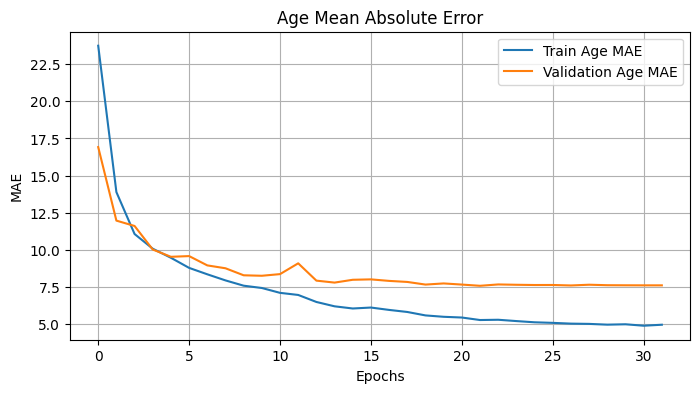

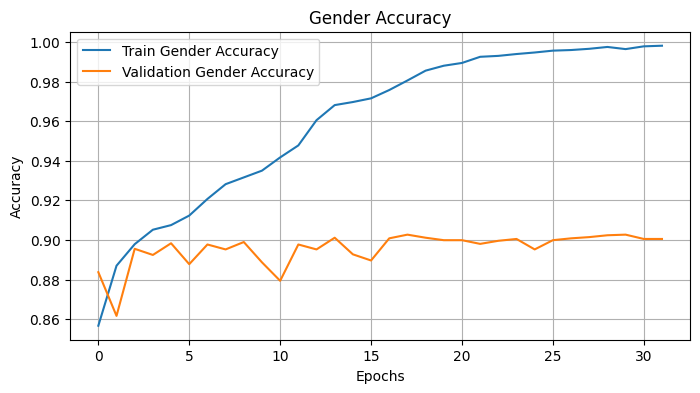

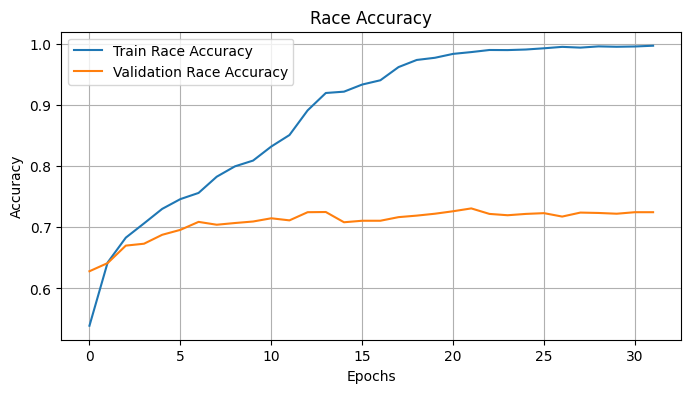

In [23]:
# Plot evaluation metrics for age, gender, and race
plt.figure(figsize=(8, 4))
plt.plot(history.history['age_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_mae'], label='Validation Age MAE')
plt.title('Age Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['gender_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['race_accuracy'], label='Train Race Accuracy')
plt.plot(history.history['val_race_accuracy'], label='Validation Race Accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [20]:
# Evaluate on the test dataset
test_loss, test_age_loss, test_gender_loss, test_race_loss, test_age_mae, test_gender_accuracy, test_race_accuracy = model.evaluate(test_ds)
print('Test Gender Accuracy:', test_gender_accuracy)
print('Test Race Accuracy:', test_race_accuracy)
print('Test Age MAE:', test_age_mae)


 47/101 [============>.................] - ETA: 5:00 - loss: 9.1393 - age_loss: 7.0734 - gender_loss: 0.3924 - race_loss: 1.1646 - age_mae: 7.5586 - gender_accuracy: 0.8956 - race_accuracy: 0.7214

Corrupt JPEG data: premature end of data segment


 65/101 [==================>...........] - ETA: 3:20 - loss: 9.0973 - age_loss: 7.0596 - gender_loss: 0.3938 - race_loss: 1.1351 - age_mae: 7.5434 - gender_accuracy: 0.8938 - race_accuracy: 0.7284

2025-07-15 12:33:10.321574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/101 [==============================] - 562s 6s/step - loss: 9.1346 - age_loss: 7.0635 - gender_loss: 0.3811 - race_loss: 1.1812 - age_mae: 7.5480 - gender_accuracy: 0.8984 - race_accuracy: 0.7212
Test Gender Accuracy: 0.8983525037765503
Test Race Accuracy: 0.7211688160896301
Test Age MAE: 7.548036575317383


In [21]:
# Save model efficientnet h5 and history pickle
with open('../models/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
model.save('../models/efficientnet_v2s_dev_0714.h5')
model.save('../models/efficientnet_v2s_dev_0714')

INFO:tensorflow:Assets written to: ../models/efficientnet_v2s_dev_0714/assets


INFO:tensorflow:Assets written to: ../models/efficientnet_v2s_dev_0714/assets


1/1 [==============================] - 3s 3s/step


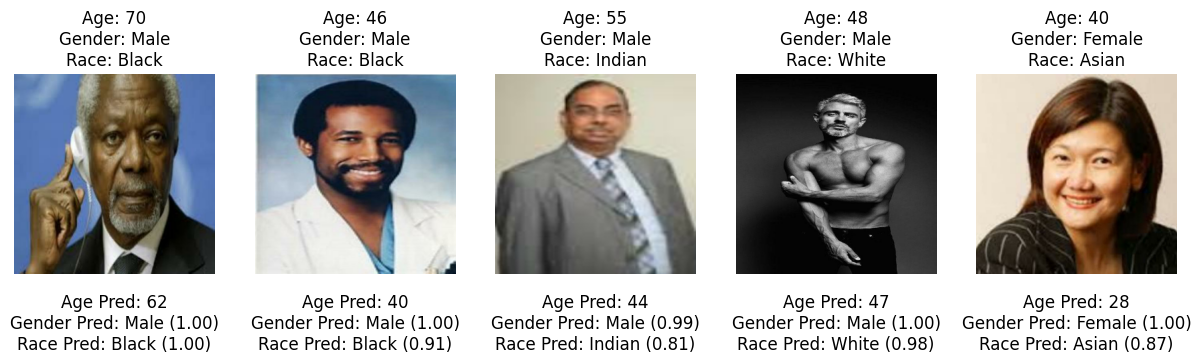

In [22]:
# Show preview image with true label and prediction from data test
for images, labels in test_ds.take(1):
    batch_size = images.shape[0]
    num_images = 5
    selected_indices = random.sample(range(batch_size), num_images)
    selected_images = tf.gather(images, selected_indices)

    ages = tf.gather(labels[0], selected_indices)
    genders = tf.gather(labels[1], selected_indices)
    races = tf.gather(labels[2], selected_indices)

    predictions = model.predict(selected_images)
    pred_ages = predictions[0].flatten()
    pred_genders = predictions[1].flatten()
    pred_races = predictions[2].argmax(axis=1)
    pred_race_confidences = predictions[2].max(axis=1)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        true_age = ages[i].numpy()
        true_gender = 'Male' if genders[i].numpy() == 0 else 'Female'
        true_race = ['White', 'Black', 'Asian', 'Indian', 'Others'][races[i].numpy()]

        pred_age = int(pred_ages[i])
        pred_gender = 'Male' if pred_genders[i] < 0.5 else 'Female'
        gender_confidence = 1 - pred_genders[i] if pred_genders[i] < 0.5 else pred_genders[i]
        pred_race = ['White', 'Black', 'Asian', 'Indian', 'Others'][pred_races[i]]
        race_confidence = pred_race_confidences[i]

        plt.subplot(1, num_images, i + 1)

        plt.imshow(selected_images[i].numpy().astype("uint8"))
        plt.title(f"Age: {true_age}\nGender: {true_gender}\nRace: {true_race}")
        plt.axis('off')

        plt.text(0.5, -0.1,
                 f"Age Pred: {pred_age}\nGender Pred: {pred_gender} ({gender_confidence:.2f})\nRace Pred: {pred_race} ({race_confidence:.2f})",
                 fontsize=12, ha='center', va='top', transform=plt.gca().transAxes)

    plt.show()